# Part 5. Time series forecasting - exercise

> Try your best in one of the Monash datasets!

Today you'll apply the knowledge acquired in part 5 to perform forecasting on one 
of the datasets from the Monash time series forecasting archive (TSF). You don't 
have to build the TSC algorithm from scratch if you don't want to, but rather make
use of high level tools. Use the ones used in previous exercises such as:
- [aeon](https://github.com/aeon-toolkit/aeon)
- [tsai](https://github.com/timeseriesAI/tsai)
- [tslearn](https://github.com/tslearn-team/tslearn#available-features)
- [sk-time](https://github.com/sktime/sktime)

Or new ones seen in this course:
- [statsmodels](https://www.statsmodels.org/stable/index.html). Implements traditional
statistical forecasting models.
- [pytorch-forecasting](https://pytorch-forecasting.readthedocs.io/en/stable/): Pytorch
library built on top of [pytorch lightning](https://lightning.ai/docs/pytorch/stable/)
that implements several neural forecasting models including NHiTS. 

We are going to use the sunspot dataset. This dataset contains a single very long 
daily time series of sunspot numbers from 1818-01-08 to 2020-05-31. Be aware that
there is missing data. The nonmissing data version of this dataset was filled with
the LOCV method of imputation.

⚠️⚠️⚠️⚠️

* url_train = 'https://zenodo.org/api/records/4654773/files-archive'
* url_test = 'https://zenodo.org/api/records/4654722/files-archive'

⚠️⚠️⚠️⚠️

In [13]:
import datetime
import time
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
from aeon.datasets import load_from_tsf_file
from aeon.utils.windowing import sliding_windows
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_error

In [5]:
missing_data, missing_metadata = load_from_tsf_file('data/sunspot_dataset_with_missing_values.tsf')
nonmissing_data, nonmissing_metadata = load_from_tsf_file('data/sunspot_dataset_without_missing_values.tsf')

print(missing_metadata)
print(nonmissing_metadata)
missing_data.head()

{'frequency': 'daily', 'forecast_horizon': None, 'contain_missing_values': True, 'contain_equal_length': True}
{'frequency': 'daily', 'forecast_horizon': None, 'contain_missing_values': False, 'contain_equal_length': True}


,series_name,start_timestamp,series_value
0,T1,1818-01-08,"[65.0, NaN, NaN, NaN, NaN, 37.0, NaN, NaN, NaN..."


## **Prepare train and test sets**

In [6]:
def to_dataframe(dataset: pd.DataFrame) -> pd.DataFrame:
    numeric_data = np.array(dataset.series_value[0])
    interval_date = datetime.timedelta(days=1) * (len(numeric_data) - 1)
    start_date = dataset.start_timestamp[0]
    date_index = pd.date_range(start_date, interval_date + start_date , freq='D')
    return pd.DataFrame(numeric_data, index=date_index, columns=['sunspot'])

In [8]:
training_data = to_dataframe(missing_data)[:datetime.datetime(2020, 1, 1)]
training_data["sunspot"] = training_data["sunspot"].astype(float)
filled_data = training_data.interpolate(method='linear', inplace=False)

# The nonmissing data starts from 2020, it is filled with LOCF, some errors are to be expected
TESTING_DATA = to_dataframe(nonmissing_data)[datetime.datetime(2020, 1, 1):]
TESTING_DATA.head()

,sunspot
2020-01-01,8.0
2020-01-02,13.0
2020-01-03,14.0
2020-01-04,12.0
2020-01-05,14.0


## **Visualize original and filled data**

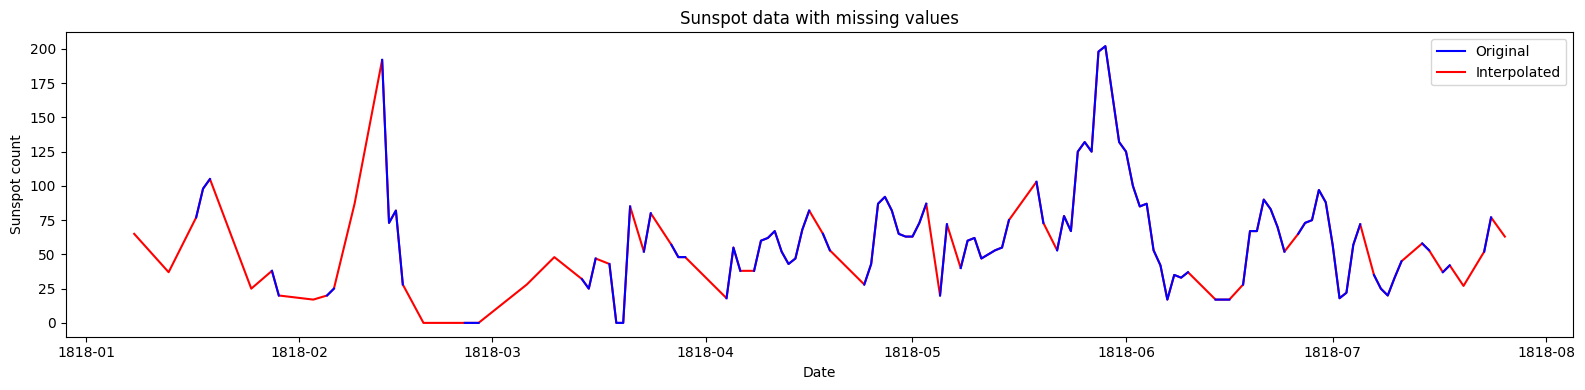

In [ ]:
plt.figure(figsize=(16,4))
plt.plot(filled_data[:200], color='red', label='Interpolated')
plt.plot(training_data[:200], color='blue', label='Original')
plt.title('Sunspot data with missing values')
plt.xlabel('Date')
plt.ylabel('Sunspot count')
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[::-1], labels[::-1])
plt.tight_layout()
plt.show()

# Task Definition

You have available a training and testing dataset. Both ``training_data`` and ``TESTING_DATA`` are not preprocessed, while training data should be preprocessed, the testing data is to never be modified in any way. The training data contains sunspot information up to (not including) 2020-01-1, while the testing data contains information from 2020-01-1 to 2020-05-31. Your task is to adequately forecast the 2020-05-31. You have to generate a forecast for each day of the testing time series. The objective metric to minimize is *RMSE*.

> Good luck!
 

## **Base ARIMA model**

****** Tiempo entrenamiento base ARIMA: 0 minutos 5 segundos ******
Base ARIMA RMSE: 81.11915790933523


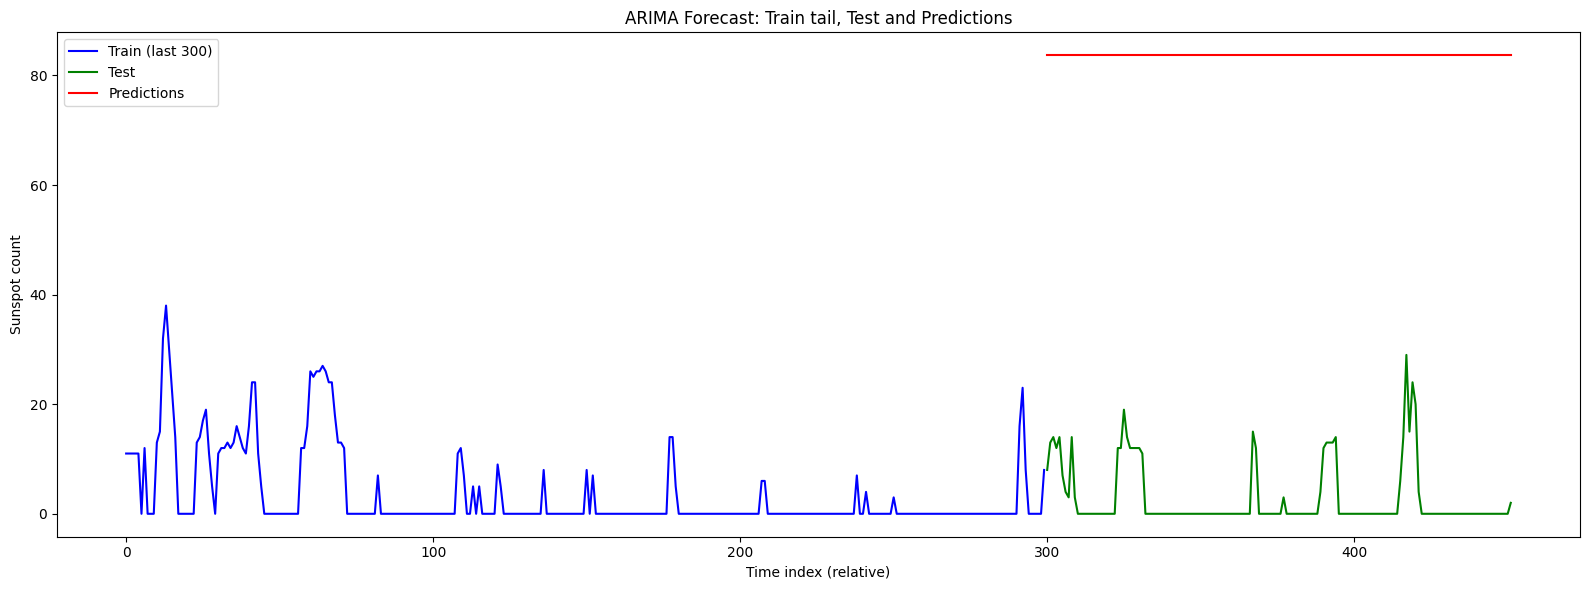

In [ ]:
train_df = filled_data['sunspot'].copy()
test_df = TESTING_DATA['sunspot'].copy()

start = time.time()
model_arima = ARIMA(train_df, order=(0,0,0))
model_arima_fit = model_arima.fit()
predictions_arima = model_arima_fit.predict(start=len(train_df), end=len(train_df) + len(test_df) - 1)
minutos, segundos = divmod(time.time() - start, 60)
print(f"****** Tiempo entrenamiento base ARIMA: {int(minutos)} minutos {int(segundos)} segundos ******")

# Plot the last 300 training values, the test data, and the corresponding predictions
train_tail = train_df[-300:]
n_test = len(test_df)
x_train = np.arange(len(train_tail))
x_test = np.arange(len(train_tail), len(train_tail) + n_test)

rmse_arima = root_mean_squared_error(test_df.to_numpy(), predictions_arima.values)
print(f"Base ARIMA RMSE: {rmse_arima}")

plt.figure(figsize=(16,6))
plt.plot(x_train, train_tail.to_numpy(), label='Train (last 300)', color='blue')
plt.plot(x_test, test_df.to_numpy(), label='Test', color='green')
plt.plot(x_test, predictions_arima.values, label='Predictions', color='red')
plt.xlabel('Time index (relative)')
plt.ylabel('Sunspot count')
plt.title('ARIMA Forecast: Train tail, Test and Predictions')
plt.legend()
plt.tight_layout()
plt.show()

## **Modified SARIMAX model**

****** Tiempo entrenamiento SARIMAX: 0 minutos 24 segundos ******
SARIMAX RMSE: 6.3974781822667905


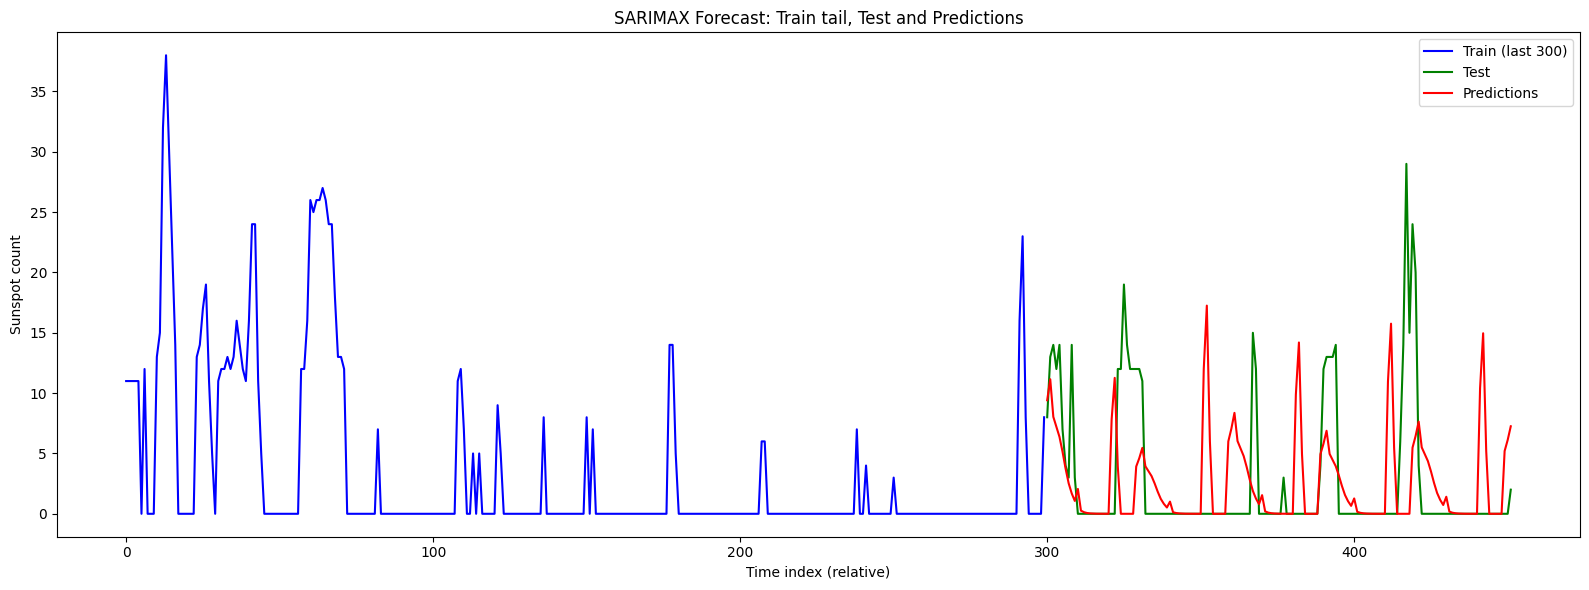

In [ ]:
train_df = filled_data['sunspot'][-4000:].copy()
test_df = TESTING_DATA['sunspot'].copy()

start = time.time()
model_sarimax = SARIMAX(train_df, order=(1, 0, 10), seasonal_order=(1, 1, 0, 30))
model_sarimax_fit = model_sarimax.fit()
predictions_sarimax = model_sarimax_fit.predict(start=len(train_df), end=len(train_df) + len(test_df) - 1)
minutos, segundos = divmod(time.time() - start, 60)
print(f"****** Tiempo entrenamiento SARIMAX: {int(minutos)} minutos {int(segundos)} segundos ******")

# Plot the last 300 training values, the test data, and the corresponding predictions
train_tail = train_df[-300:]
n_test = len(test_df)
x_train = np.arange(len(train_tail))
x_test = np.arange(len(train_tail), len(train_tail) + n_test)

rmse_sarimax = root_mean_squared_error(test_df.to_numpy(), predictions_sarimax.values)
print(f"SARIMAX RMSE: {rmse_sarimax}")

plt.figure(figsize=(16,6))
plt.plot(x_train, train_tail.to_numpy(), label='Train (last 300)', color='blue')
plt.plot(x_test, test_df.to_numpy(), label='Test', color='green')
plt.plot(x_test, predictions_sarimax.values, label='Predictions', color='red')
plt.xlabel('Time index (relative)')
plt.ylabel('Sunspot count')
plt.title('SARIMAX Forecast: Train tail, Test and Predictions')
plt.legend()
plt.tight_layout()
plt.show()

## **LSTM model**

**Aeon sliding window** (por si sirve de algo)

In [12]:
entire_df = pd.concat((filled_data, TESTING_DATA)).copy()
print(f"All data shape: {entire_df.shape}")
print(f"Testing data shape: {TESTING_DATA.shape}")

window_size = 120
all_windows, _ = sliding_windows(entire_df['sunspot'], window_size=window_size, stride=1)
y = [all_windows[i+1][-1] for i in range(len(all_windows)-1)]
all_windows = all_windows[:-1]

training_windows = all_windows[:len(filled_data)-window_size]
testing_windows = all_windows[len(filled_data)-window_size:]
y_train = y[:len(filled_data)-window_size]
y_test = y[len(filled_data)-window_size:]

print(f"***** {len(training_windows), len(y_train), len(testing_windows), len(y_test)} *****")

All data shape: (73925, 1)
Testing data shape: (152, 1)
***** (73653, 73653, 152, 152) *****


---

In [ ]:
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train_df.values)
test_scaled = scaler.transform(test_df.values)

train_scaled = pd.DataFrame(train_scaled, columns=train_df.columns)
test_scaled = pd.DataFrame(test_scaled, columns=test_df.columns)

In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size)
        self.linear = nn.Linear(hidden_layer_size, output_size)
        self.reset_hidden_cell()

    def reset_hidden_cell(self):
        self.hidden_cell = (torch.zeros(1,self.hidden_layer_size), torch.zeros(1,self.hidden_layer_size))
        
    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq, self.hidden_cell)
        return self.linear(lstm_out)

# Prepare data for LSTM
train_data_normalized = torch.FloatTensor(training_windows)

model = LSTM(input_size=2, hidden_layer_size=50, output_size=2)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

epochs = 100
trace = 10
loss_history = []
rmse_history = []
train_inout_seq = []
for i in range(len(train_data_normalized)-window_size):
    seq = train_data_normalized[i:i+window_size].view(-1, window_size, 1)
    label = torch.FloatTensor([y_train[i+window_size]]).view(-1, 1, 1)
    train_inout_seq.append((seq, label))

start = time.time()
for i in range(epochs):
    epoch_loss = 0
    epoch_rmse = 0
    random.shuffle(train_inout_seq) # Randomize the training data
    for seq, labels in train_inout_seq:
        optimizer.zero_grad()
        model.reset_hidden_cell()
        y_pred = model(seq)

        single_loss = loss_function(y_pred.squeeze(), labels)
        single_loss.backward()
        optimizer.step()
        
        with torch.no_grad():
            epoch_loss += single_loss/len(train_inout_seq)
            epoch_rmse += root_mean_squared_error(scaler.inverse_transform(labels.detach().numpy()), 
                                            scaler.inverse_transform(y_pred.squeeze().detach().numpy())
                         )/len(train_inout_seq)

    if i % trace == 0:
        print(f'Epoch {i} loss: {epoch_loss}; RMSE: {epoch_rmse}')

minutos, segundos = divmod(time.time() - start, 60)
print(f"***** Tiempo entrenamiento LSTM: {int(minutos)} minutos {int(segundos)} segundos *****")